# Spring 2023 Experimental Mathematics Lab 

**Advisor:** Dr. Padi Fuster; **Students:** Chelsea Eakins, Graham Mauer

**We advise that you make a copy of this .ipynb file in your own drive or download the file to your own computer to view this project.**

**Description:** From the Greek, taxis meaning movement, chemotaxis is the movement of an organism in response to a chemical stimulus. The movement of sperm towards an egg during fertilization or of bacteria attracted towards a source of food are examples of chemotaxis. This phenomenon is usually modeled by a type of PDE systems called reaction-diffusion equations, which also have applications in epidemiology, ecology, and the social sciences.

In this lab, we studied a particular PDE model for chemotaxis with logarithmic sensitivity and a generalized logistic growth and to better understand the qualitative behavior of its solution. We performed numerical simulations using Python and learned more about how the non-dimensional parameters of our equations affect the behavior of solutions.

**Method:** We implement an adapted Keller-Segel model for chemotaxis in 1D on the interval $[0,1]$ featuring logarithmic sensitivity and generalized logistic growth. The logarthmic sensitivy allows an organism to detect small changes in chemical concentration in a saturated solution (think swimming in the ocean and being able to taste some ocean water being saltier than other ocean water) and the generalized logistic growth allows for the population of organisms to grow with different characteristics than the logistic growth equation, which can be representative of different environmental characteristics.

$$
\begin{align}
    u_t &= u_{xx} - (uv)_x + ru(1-u^{\alpha}) \\
    v_t &= \varepsilon_1v_{xx}+\varepsilon_2\left(v^2\right)_x -u_x
\end{align}
$$
As for boundary conditions:
$$
\begin{align}
    u_x(0) = 0&, u_x(1) = 0 \\
    v(0) = 0&, v(1) = 0
\end{align}
$$

Above, $t$ and $x$ subscripts represent time and spatial derivatives respectively. 

$u$ is the population density and $v$ is the relative rate of change of the chemical concentration. Both $u$ and $v$ are scalar functions and $u$ is strictly positive over the domain for physical reasons (can't have negative population).

The equations above are dimensionless, and $r$, $\varepsilon_1$ and $\varepsilon_2$ are relative time-scales.

$r$  indicates the relative time-scale at which the population approaches the carrying capacity -- the maximum density of organisms the environment can support. It is labelled 'coeff1' in the code.

$\varepsilon_1$ and $\varepsilon_2$ are the relative time-scales for diffusion and advection of $v$ respectively. 

Finally, $\alpha$ changes the kind of logarithmic growth present in the system, with $\alpha=1$ being the usual logarithmic growth.



The equations above are implemented below using a second order finite difference scheme. 

In [ ]:
# Array math
import numpy as np

# Plotting and animations
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

# Making and reading .csv files
import pandas as pd
import csv

class Chemotaxis:
    
    def __init__(self, params):
        
        '''
        OVERVIEW
        --------
        
        This is the __init__ or initialization function for the code. Everything runs in here.
        
        First, it does a bunch of precalculations. Then, it sets up the bounds, spacing, and 
        initial conditions. Finally, it simulates the system of PDEs.
        
        USAGE INSTRUCTIONS
        ------------------
        
        Define your params dictionary and both inital condition functions, then run:
        'Chemotaxis(params)' on its own line. 
        
        INPUTS
        ------
        
            params : This is a nested dictionary that contains all the instructions for the
                     code to run. All parameters are defined there.
            
        RETURNS
        -------
        
            1) This code will only print or output results that 'params' input tells it to. 
            
            Note: The `Analysis` class uses the outputs from the `Chemotaxis` class to analyze outputs.
               
        Things to watch out for:
        ------------------------
        
            1) Be careful of long runtime and large 'N' values. This simulation is RAM intensive
               and creating any huge arrays could cause a crash. For anything reasonable it will
               be fine, but if you want hour-long animations you'll probably run into some trouble.
               
        '''
        
        if params['code_params']['verbose'] == True:
            
            print(f'\n####################\nStarting Simulations\n####################\n')
            
        # Input parameters
        self.N      = params['simulation_params']['N']
        self.ep1    = params['simulation_params']['ep1']
        self.ep2    = params['simulation_params']['ep2']
        self.coeff1 = params['simulation_params']['coeff1']
        self.T      = params['simulation_params']['T']
        self.alphas = params['simulation_params']['alphas']
        
        if params['code_params']['verbose'] == True:
            
            print(f'''N:      {self.N}\nep1:    {self.ep1}\nep2:    {self.ep2}\ncoeff1: {self.coeff1}\nT:      {self.T}\nAlphas: {self.alphas}''')
        
        # Checking that the format is correct for all the important inputs
        assert type(self.N)      != "<class 'int'>"  , "Invalid variable type for N, must be an integer"
        assert type(self.ep1)    != "<class 'float'>", "Invalid variable type for ep1, must be a float"
        assert type(self.ep2)    != "<class 'float'>", "Invalid variable type for ep2, must be a float"
        assert type(self.coeff1) != "<class 'float'>", "Invalid variable type for coeff1, must be a float"
        assert type(self.T)      != "<class 'float'>" or type(self.T) != "<class 'int'>", "Invalid variable type for T, must be a float or integer" 
        
        # Pre-calucations
        self.h      = 1.0 / self.N
        self.inv_h  = 1.0 / self.h
        self.inv_h2 = 1.0 / (self.h ** 2)
        self.inv_2h = 1.0 / (2.0 * self.h)
        self.dt      = self.h ** 2 / 2.0
        
        # Plotting initial conditions
        if params['visualization_params']['plot_inital_conditions'] == True:
            
            plt.plot(np.linspace(0,1,100), params['simulation_params']['u_initial'](np.linspace(0,1,100)), c='tab:blue', label='u')
            plt.plot(np.linspace(0,1,100), params['simulation_params']['v_initial'](np.linspace(0,1,100)), c='tab:orange', label='v')
            plt.legend(loc='upper right')
            plt.title('Initial Conditions [t=0.0]')
            plt.xlabel('x')
            plt.ylabel('Concentration')
            plt.show()
            if params['visualization_params']['save_inital_conditions'] == True:
            
                if params['code_params']['verbose'] == True:
            
                    print(f"\tSaving initial conditions as {params['code_params']['batch_name']}_inital_conditions.png")
                
                plt.savefig(f"{params['code_params']['batch_name']}_inital_conditions.png")
                plt.close()
        
        #######################
        # Set up the simulation
        #######################
        
        for alpha in range(len(self.alphas)):
            
            if params['code_params']['verbose'] == True:
            
                print(f'\n{alpha + 1}/{len(self.alphas)} : alpha = {self.alphas[alpha]}\n')

        
            # x values
            self.xv    = self.h * np.linspace(0,self.N,self.N+1)
            self.xu    = self.h * np.linspace(1/2,self.N-1/2, self.N)
            self.xuAUG = self.h * np.linspace(-1/2,self.N+1/2, self.N+2)
        
            # y values
            self.u0 = params['simulation_params']['u_initial'](self.xu)
            self.v0 = params['simulation_params']['v_initial'](self.xv)
        
            # Implementing the first boundary conditions
            self.uAUG       = np.zeros_like(self.xuAUG)
            self.uAUG[1:-1] = self.u0
            self.uAUG[0]    = self.u0[0]
            self.uAUG[-1]   = self.u0[-1]
            #self.uAUG0 = self.uAUG
        
            self.v0[0]  = 0
            self.v0[-1] = 0
        
            # Assigning the u and v variables that get used for the rest of the code
            #self.uAUG = self.uAUG0
            self.v = self.v0
            
            self.current_a = self.alphas[alpha]
        
            if params['csv_params']['output_csv'] == True:
            
                if params['code_params']['verbose'] == True:
            
                    print(f"\tSimulating the system and saving to a .csv file at {params['code_params']['batch_name']}_u_a{self.alphas[alpha]}_e{self.ep1}_r{self.coeff1}.csv and {params['code_params']['batch_name']}_v_a{self.alphas[alpha]}_e{self.ep1}_r{self.coeff1}.csv")
            
                self.Simulate_Chemotaxis_csv()
            
            if params['animation_params']['create_animation'] == True:
            
                if params['code_params']['verbose'] == True:
            
                    print(f"\tSaving animation as a .{params['animation_params']['file_type']} file at {params['code_params']['batch_name']}_a{self.alphas[alpha]}_e{self.ep1}_r{self.coeff1}.{params['animation_params']['file_type']}")
        
                self.Simulate_Chemotaxis_anim()
            
            if params['animation_params']['create_animation'] == False and params['csv_params']['output_csv'] == False:
            
                if params['code_params']['verbose'] == True:
            
                    print(f'\tSimulating the system. Creating no animation and outputting no .csv file')
            
                self.Simulate_Chemotaxis()
                
        if params['code_params']['verbose'] == True: 
            
            print('\nSimulations Finished!')
    
    def Dirchlet_BC(self, **kwargs):
        
        '''
        Initializes Dirichlet boundary conditions on the 'v' function
        '''
          
        self.v[0] = 0
        self.v[-1] = 0
        
    def Neumann_BC(self, **kwargs):
         
        '''
        Initializes Neumann boundary conditions on the 'u' function
        '''
           
        self.uAUG[0] = self.uAUG[1]
        self.uAUG[-1] = self.uAUG[-2]
        
    def Simulate_Chemotaxis(self, **kwargs):
        
        '''
        Moves the system forward one time step. Calculates all the derivatives
        and moves it forward by 'dt'. Also restablishes boundary conditions each
        time step. 
        '''
        
        # Calculate needed derivatives
        self.ux = self.inv_h * (self.uAUG[1:-1] - self.uAUG[0:-2])
        self.uxx = self.inv_h2 * (self.uAUG[2:] - 2 * self.uAUG[1:-1] + self.uAUG[0:-2])
    
        self.vx = self.inv_h * (self.v[1:-1] - self.v[0:-2])
        self.vxx = self.inv_h2 * (self.v[2:] - 2 * self.v[1:-1] + self.v[0:-2])
    
        self.v2x = self.inv_2h * (self.v[2:] ** 2 - self.v[:-2] ** 2)
        self.uvx = self.inv_2h * ((self.uAUG[1:-1] + self.uAUG[2:]) * self.v[1:] - (self.uAUG[1:-1] + self.uAUG[0:-2]) * self.v[:-1])
    
        # Time advance the equations
        self.uAUG[1:-1] = self.uAUG[1:-1] + self.dt * ( self.uxx - self.uvx + self.coeff1 * self.uAUG[1:-1] * (1 - np.power(self.uAUG[1:-1], self.current_a) )) # np.power is faster for non-integer exponents
        self.v[1:-1] = self.v[1:-1] + self.dt * ( self.ep1 * self.vxx + self.ep2 * self.v2x - 0.5 * (self.ux[:-1] + self.ux[1:]) ) # Must drop ux down to midpoints to compare to v calculations. 
    
        # Establish the Neumann B.C. for u
        self.Neumann_BC()
    
        # Establish Dirichlet B.C. for v   
        self.Dirchlet_BC()
        
    def Simulate_Chemotaxis_anim(self, **kwargs):
        
        # Creates arrays to store critical animation data.
        t_array = np.array([])
        u_array = np.array([self.uAUG])
        v_array = np.array([self.v])
        
        # Calculates how many timesteps there are in the runtime and starts a for loop.
        for k in range(int(self.T // self.dt) + 2):
            
            # Propogate the system forwards a timestep
            self.Simulate_Chemotaxis()
                   
            # Recording data for animation
            if k % params['animation_params']['frame_frequency'] == 0:
                
                t_array = np.append(t_array, k*self.dt)
                u_array = np.append(u_array, [self.uAUG], axis=0)
                v_array = np.append(v_array, [self.v], axis=0)
        
        # Create the animation axes and prepare them for plotting
        fig, ax = plt.subplots(figsize=params['animation_params']['figure_size'], dpi=params['animation_params']['dpi']);
        ax.set_xlim((-0.05, 1.05));
        ax.set_ylim((-0.05, 2));
        u_line, = ax.plot([], [], c='tab:blue', label='u');
        v_line, = ax.plot([], [], c='tab:orange', label='v');
        ax.legend();
            
        def animate(i):
            
            '''
            This function is ran like a for loop, and returns lines to be plotted for each frame of the animation.
            
            The only thing I would change here is how the title is formatted. Everything is pretty set in stone. If
            you want to animate a third line, simply add it with the same pattern as u_line and v_line.
            '''
                
            ax.set_title(f't = {t_array[i]:0.4}, u_max = {np.max(u_array[i]):0.4f}, u_avg = {np.mean(u_array[i]):0.4f}');
                
            u_line.set_data(self.xuAUG, u_array[i]);
            v_line.set_data(self.xv, v_array[i]);
            
            return (u_line, v_line,);
        
        # Creates the animation object
        ani = animation.FuncAnimation(fig, # Calls the figure object created above
                                      animate, # Calls animation function defined above
                                      frames = int((int(self.T // self.dt) / params['animation_params']['frame_frequency']) + 2), # Calculates the total number of frames in the animation
                                      interval = int(1000 / params['animation_params']['fps']), # Calculates interval between frames in milliseconds
                                      blit=True); # A necessary instruction on how to draw the frames.
        
        # Saves the animation to memory
        writer = PillowWriter(fps=params['animation_params']['fps'])
        ani.save(f"{params['code_params']['batch_name']}_a{self.current_a}_e{self.ep1}_r{self.coeff1}.{params['animation_params']['file_type']}", writer=writer)
        plt.close()
            
    def Simulate_Chemotaxis_csv(self, **kwargs):
        
        if params['csv_params']['simulation_data_as_header'] == True:
            
            with open(f"{params['code_params']['batch_name']}_u_a{self.current_a}_e{self.ep1}_r{self.coeff1}.csv", "wt") as fp:

                fp.write(f'# N = {self.N}\n')
                fp.write(f'# ep1 = {self.ep1}\n')
                fp.write(f'# ep2 = {self.ep2}\n')
                fp.write(f'# coeff1 = {self.coeff1}\n')
                fp.write(f'# T = {self.T}\n')
                fp.write(f'# alphas = {self.current_a}\n')
                fp.write(f'# \n')
                fp.write(f"# Save frequency = {params['csv_params']['save_frequency']}\n")
                fp.write(f'# \n')

                writer = csv.writer(fp)
                
            with open(f"{params['code_params']['batch_name']}_v_a{self.current_a}_e{self.ep1}_r{self.coeff1}.csv", "wt") as fp:

                fp.write(f'# N = {self.N}')
                fp.write(f'# ep1 = {self.ep1}')
                fp.write(f'# ep2 = {self.ep2}')
                fp.write(f'# coeff1 = {self.coeff1}')
                fp.write(f'# T = {self.T}')
                fp.write(f'# alphas = {self.current_a}')
                fp.write(f'# ')
                fp.write(f"# Save frequency = {params['csv_params']['save_frequency']}")
                fp.write(f'# ')

                writer = csv.writer(fp)
        
        # Calculates how many timesteps there are in the runtime and starts a for loop.
        for k in range(int(self.T // self.dt) + 2):
            
            # Propogate the system forwards a timestep
            self.Simulate_Chemotaxis()
                   
            # Saving data for .csv creation. Should change this
            if k % params['csv_params']['save_frequency'] == 0:
                
                # Create the 'pandas DataFrame' that contains the time step information and add it to the existing.csv file
                DF_u = pd.DataFrame.transpose(pd.DataFrame(np.concatenate(([k*self.dt, np.mean(self.uAUG)], self.uAUG))))
                DF_u.to_csv(f"{params['code_params']['batch_name']}_u_a{self.current_a}_e{self.ep1}_r{self.coeff1}.csv", mode='a', index=False, header=False)
                
                DF_v = pd.DataFrame.transpose(pd.DataFrame(np.concatenate(([k*self.dt, np.mean(self.v)], self.v))))
                DF_v.to_csv(f"{params['code_params']['batch_name']}_v_a{self.current_a}_e{self.ep1}_r{self.coeff1}.csv", mode='a', index=False, header=False)
        
class Analysis:
    
    def __init__(self, params):
    
        '''
        OVERVIEW
        --------
        
        This is the initialization function for the analysis code.
        
        First, it reads in parameters and does some precalculations. Then, it determines what files
        it should read in, and saves that data to an array. It then calculates some characteristic times
        for the data it read in and saves it to a final .csv file if desired. 
        
        USAGE INSTRUCTIONS
        ------------------
        
        Define your params dictionary and both inital condition functions, then run:
        'Analysis(params)' on its own line. Make sure that there are some .csv files
        generated by the Chemotaxis class, otherwise nothing will happen.
        
        INPUTS
        ------
        
            params : This is a nested dictionary that contains all the instructions for the
                     code to run. All parameters are defined there.
            
        RETURNS
        -------
        
            This code will only print or output results that 'params' input tells it to.
            
            Flattening Times:
            
                This code calculates the time it takes for the solution of u to 'flatten' within some
                norm. It produces this result in two ways: firstly the difference of u from its own average,
                and secondly by evaluating when the second derivative is sufficiently close to 0.
            
            Arrived at Average:
            
                Often, u approaches it's initial average before it grows to it's carrying capacity.
                This code calculates the time it takes for the solution to reach it's initial average 
                within some norm. 
            
            Left Average:
            
                Similar to above, but what time do the solutions of u depart from the initial average and tend
                towards the carrying capacity? This is defined as 'when is the first time the norm at the average
                is not satisfied?'.
            
            Arrived at Carrying Capacity:
            
                What time does the solution of u approach the carrying capacity (in this case 1)? This code 
                again uses a norm to determine this. 
                
        NOTES
        -----
        
            If the Chemotaxis class isn't run for sufficient time it can be difficult to find adequate results for 
            the Analysis class. Set T ~ 20 and try again if needed. 
            
        '''
        
        if params['code_params']['verbose'] == True:
            
            print(f'\n##################\nBeginning Analysis\n##################\n')
        
        # Input parameters
        self.N      = params['simulation_params']['N']
        self.ep1    = params['simulation_params']['ep1']
        self.ep2    = params['simulation_params']['ep2']
        self.coeff1 = params['simulation_params']['coeff1']
        self.T      = params['simulation_params']['T']
        self.alphas = params['simulation_params']['alphas']
        
        # Precalculations
        self.h = 1.0 / self.N
        self.inv_h2 = 1.0 / (self.N ** 2)
        
        # Write all the .csv filenames to a list so they can be iterated to
        self.filenames_u = []
        self.filenames_v = []
        
        # Generate the filenames given what params were entered
        for alpha in self.alphas:
            
            self.current_a = alpha
            
            self.filenames_u.append(f"{params['code_params']['batch_name']}_u_a{self.current_a}_e{self.ep1}_r{self.coeff1}.csv")
            
            self.filenames_v.append(f"{params['code_params']['batch_name']}_v_a{self.current_a}_e{self.ep1}_r{self.coeff1}.csv")
        
        # Find the requested times
        if params['analysis_params']['times_to_csv']['execute'] == True:
            
            if params['analysis_params']['flattening_times']['execute'] == True:
            
                self.find_flattening_times()
        
            if params['analysis_params']['flattening_times_2nd_der']['execute'] == True:
            
                self.find_flattening_times_2nd_der()
        
            if params['analysis_params']['time_arrived_and_left_initial_average']['execute'] == True:
        
                self.find_time_arrived_and_left_initial_average()
            
            if params['analysis_params']['time_to_carrying_capacity']['execute'] == True:
        
                self.find_time_to_carrying_capacity()
                
            if params['analysis_params']['times_to_csv']['execute'] == True :
        
                self.times_to_csv()
            
        if params['code_params']['verbose'] == True:
            
            print(f'Analysis Finished!')
        

    def times_to_csv(self):
        
        '''
        Write the desired times to a .csv file. The first lines are comments with simulation specifics.
        '''
        
        if params['code_params']['verbose'] == True:
            
            print(f"\n\tWriting requested times to .csv at {params['code_params']['batch_name']}_characteristic_times_a{self.current_a}_e{self.ep1}_r{self.coeff1}.csv\n")
                    
        with open(f"{params['code_params']['batch_name']}_characteristic_times_e{self.ep1}_r{self.coeff1}.csv", "wt") as fp:

                fp.write(f'# N = {self.N}\n')
                fp.write(f'# ep1 = {self.ep1}\n')
                fp.write(f'# ep2 = {self.ep2}\n')
                fp.write(f'# coeff1 = {self.coeff1}\n')
                fp.write(f'# T = {self.T}\n')
                fp.write(f'# alphas = {self.alphas}\n')
                fp.write(f'# \n')
                fp.write(f"# Save frequency = {params['csv_params']['save_frequency']}\n")
                fp.write(f'# \n')

                writer = csv.writer(fp)
        
        for i in range(len(self.alphas)):
            
            times = pd.DataFrame.transpose(pd.DataFrame(np.array([[self.flattening_times[i]], [self.flattening_times_2nd_der[i]], [self.arrived_initial_average_times[i]], [self.left_initial_average_times[i]], [self.times_to_carrying_capacity[i]]])))
            times.to_csv(f"{params['code_params']['batch_name']}_characteristic_times_e{self.ep1}_r{self.coeff1}.csv", mode='a', index=False, header=False)
                     
    def find_flattening_times(self, **kwargs):
        
        '''
        Find the time it took for u to flatten out by its initial diffusion by ||u||^n < eps
        '''
        
        self.flattening_times = np.zeros_like(self.alphas)
        for alpha in range(len(self.alphas)):
            
            u_data = np.array(pd.read_csv(self.filenames_u[alpha],comment='#',delimiter =',',header=None))
            
            
            for t in range(len(u_data[:,0])):
                
                u_norm = np.sum(((u_data[t,2:] - u_data[t,1])) ** params['analysis_params']['flattening_times']['norm'])
                
                if u_norm <= params['analysis_params']['flattening_times']['epsilon']:
                    
                    self.flattening_times[alpha] = u_data[t,0]
                    
                    break
        
        if params['code_params']['verbose'] == True:
            
            print(f'\tFlattening Times: {self.flattening_times}')
            
    def find_flattening_times_2nd_der(self, **kwargs):
        
        '''
        Find the time it took for u to flatten out by its initial diffusion by taking the ||u_xx||^n < eps
        '''
        
        self.flattening_times_2nd_der = np.zeros_like(self.alphas)
        for alpha in range(len(self.alphas)):
            
            u_data = np.array(pd.read_csv(self.filenames_u[alpha],comment='#',delimiter =',',header=None))
            
            for t in range(len(u_data[:,0])):
                
                u_norm = np.sum((self.N**2*(u_data[t,4:] - 2 * u_data[t,3:-1] + u_data[t,2:-2])) ** params['analysis_params']['flattening_times_2nd_der']['norm'])
                
                if u_norm <= params['analysis_params']['flattening_times_2nd_der']['epsilon'] * self.N:
                    
                    self.flattening_times_2nd_der[alpha] = u_data[t,0]
                    
                    break
        
        if params['code_params']['verbose'] == True:
            
            print(f'\tFlattening Times (2nd der): {self.flattening_times_2nd_der}')
              
    def find_time_arrived_and_left_initial_average(self, **kwargs):
        
        '''
        Find the time it took for u to reach its initial average and the time
        it took to leave its initial average by ||u - mean(u(t=0))||^n < eps
        '''
              
        self.arrived_initial_average_times = np.zeros_like(self.alphas)
        self.left_initial_average_times = np.zeros_like(self.alphas)
        
        for alpha in range(len(self.alphas)):
            
            t_count = 0
            
            u_data = np.array(pd.read_csv(self.filenames_u[alpha],comment='#',delimiter =',',header=None))
            
            # Determine when it arrives at the average
            for t in range(len(u_data[:,0])):
                
                t_count += 1
                
                u_norm = np.sum((u_data[t,2:] - u_data[0,1]) ** params['analysis_params']['time_arrived_and_left_initial_average']['norm'])
                
                if u_norm <= params['analysis_params']['time_arrived_and_left_initial_average']['epsilon']:
                    
                    self.arrived_initial_average_times[alpha] = u_data[t,0]
                    
                    break
            
            # Determine when it leaves the average
            for t in range(len(u_data[:,0]) - t_count):
                
                u_norm = np.sum((u_data[t+t_count,2:] - u_data[0,1]) ** params['analysis_params']['time_arrived_and_left_initial_average']['norm'])
                
                if u_norm >= params['analysis_params']['time_arrived_and_left_initial_average']['epsilon']:
                    
                    self.left_initial_average_times[alpha] = u_data[t,0]
                    
                    break
        
        if params['code_params']['verbose'] == True:
            
            print(f'\tArrived at Initial Average Times: {self.arrived_initial_average_times}')
            print(f'\tLeft Average Times: {self.left_initial_average_times}')
            
    def find_time_to_carrying_capacity(self, **kwargs):
        
        '''
        Find the time it took for u to reach the carrying capacity by ||u - 1||^n < eps
        '''
        
        self.times_to_carrying_capacity = np.zeros_like(self.alphas)
        for alpha in range(len(self.alphas)):
            
            u_data = np.array(pd.read_csv(self.filenames_u[alpha],comment='#',delimiter =',',header=None))
            
            ones_array = np.ones_like(u_data[0,2:])
            
            for t in range(len(u_data[:,0])):
                
                u_norm = np.sum((u_data[t,2:] - ones_array) ** params['analysis_params']['time_to_carrying_capacity']['norm'])
                
                if u_norm <= params['analysis_params']['time_to_carrying_capacity']['epsilon'] * self.N:
                    
                    self.times_to_carrying_capacity[alpha] = u_data[t,0]
                    
                    break
        
        if params['code_params']['verbose'] == True:
            
            print(f'\tCarrying Capacity Times: {self.times_to_carrying_capacity}')
        
        

In [ ]:
def u_init(x):
    '''
    Input a numpy array of x values and obtain a numpy array of the
    same size that has the values of the function below.
    '''
    return 0.3 + 0.25 * np.sin(x ** 2 * 2.0 * np.pi)

def v_init(x):
    '''
    Input a numpy array of x values and obtain a numpy array of the
    same size that has the values of the function below.
    '''
    return 10.0 * np.exp(-(x - 1/2) ** 2 * 18.0) / 6.0


####################
Starting Simulations
####################

N:      200
ep1:    0.01
ep2:    0.01
coeff1: 1
T:      2.5
Alphas: [0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]


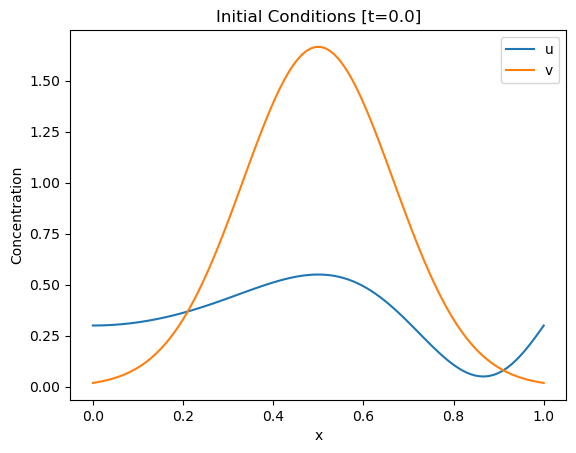

	Saving initial conditions as DEMO_inital_conditions.png

1/9 : alpha = 0.0

	Simulating the system and saving to a .csv file at DEMO_u_a0.0_e0.01_r1.csv and DEMO_v_a0.0_e0.01_r1.csv
	Saving animation as a .gif file at DEMO_a0.0_e0.01_r1.gif

2/9 : alpha = 0.25

	Simulating the system and saving to a .csv file at DEMO_u_a0.25_e0.01_r1.csv and DEMO_v_a0.25_e0.01_r1.csv
	Saving animation as a .gif file at DEMO_a0.25_e0.01_r1.gif

3/9 : alpha = 0.5

	Simulating the system and saving to a .csv file at DEMO_u_a0.5_e0.01_r1.csv and DEMO_v_a0.5_e0.01_r1.csv
	Saving animation as a .gif file at DEMO_a0.5_e0.01_r1.gif

4/9 : alpha = 0.75

	Simulating the system and saving to a .csv file at DEMO_u_a0.75_e0.01_r1.csv and DEMO_v_a0.75_e0.01_r1.csv
	Saving animation as a .gif file at DEMO_a0.75_e0.01_r1.gif

5/9 : alpha = 1.0

	Simulating the system and saving to a .csv file at DEMO_u_a1.0_e0.01_r1.csv and DEMO_v_a1.0_e0.01_r1.csv
	Saving animation as a .gif file at DEMO_a1.0_e0.01_r1.gif

6/9 : alp

In [ ]:
params = {
    'code_params' : {
        'verbose' : True,                    # Boolean T/F     : This prompts the program to print what it is doing. Good for debugging or knowing where the code is at for a large set of parameters
        'batch_name' : 'DEMO',               # string          : Assigns a string as a header to every file created with this set of parameters. Use for identifying data from multiple simulations.
    },
    'visualization_params' : {
        'plot_inital_conditions' : True,     # Boolean T/F     : Show a plot of the inital conditons
        'save_inital_conditions' : True,     # Boolean T/F     : Save a plot of the inital conditons
        'figure_size' : (7,4),               # tuple           : Size of inital conditions plot
        'dpi' : 180,                         # int             : Resolution of inital conditions plot
    },
    'simulation_params' : {
        'N' : 200,                           # int             : Number of parts interval [0,1] is broken into
        'ep1' : 0.01,                        # float           : Coeffificient of diffusion of v
        'ep2' : 0.01,                        # float           : Coefficient of advection of v
        'coeff1' : 1,                        # float           : Logisic term coefficient
        'T' : 2.5,                           # float           : Total runtime
        'alphas' : np.linspace(0,2,9),       # numpy array     : Different values of alpha to be simulated
        'u_initial' : u_init,                # function object : Function describing initial distribution of u
        'v_initial' : v_init,                # function object : Function describing initial distribution of v
    },
    'csv_params' : {
        'output_csv' : False,                # Boolean T/F     : Create and save a .csv output of the simulation
        'save_frequency' : 5000,             # int             : Every ___ timesteps, save the data to the .csv file
        'simulation_data_as_header' : True,  # Boolean T/F     : Writes the parameters of the simulation and .csv creation in the first rows of the .csv file
    },  
    'animation_params' : {
        'create_animation' : True,           # Boolean T/F     : Create and save an animation
        'file_type' : 'gif',                 # string          : .mp4 files have problems on Apple machines. Use .gif    
        'fps' : 30,                          # int             : Frames per second for the animation (only works for .mp4 files not gifs)
        'frame_frequency' : 500,             # int             : 1 in every ___ iterations get saved to the animation. Typical simulation is on order of 1e5 iterations
        'dpi' : 50,                          # int             : Resolution. larger dpi -> higher resolution -> slower runtime + more RAM usage
        'writer' : 'Pillow',                 # not implemented : Has no use as of now, just for reference
        'figure_size': (7, 4),               # tuple           : Size of the animation figure
        'save_animation_data' : False,       # Boolean T/F     : Not implemented
    },
    'analysis_params' : {
        'flattening_times' : {
            'execute' : True,
            'norm' : 2,                      # int     : Norm are we looking at this in
            'epsilon' : 0.01,                # float   : Value of the norm that is sufficiently close
        },
        'flattening_times_2nd_der' : {
            'execute' : True,
            'norm' : 2,                      # int     : Norm are we looking at this in
            'epsilon' : 0.01,                # float   : Value of the norm that is sufficiently close
        },
        'time_arrived_and_left_initial_average' : {
            'execute' : True,
            'norm' : 2,                      # int     : Norm are we looking at this in
            'epsilon' : 0.05,                # float   : Value of the norm that is sufficiently close
        },
        'time_to_carrying_capacity' : {
            'execute' : True,
            'norm' : 2,                      # int     : Norm are we looking at this in
            'epsilon' : 0.01,                # float   : Value of the norm that is sufficiently close
        },
        'times_to_csv' : {
            'execute' : True,                # Boolean : Save above times to a .csv file
        },
    },
}

Chemotaxis(params);
Analysis(params);

**Note:** Because the parameters above are 'demo' parameters, they are focuses more on visual results. Thus, they fail to satisfy much of the criteria for the analysis class to function as intended. If you'd like to look at those results, change `T` above to something like 20, but be prepared for a longer runtime. 